In [1]:
import model.fdtd as oNN
import config as cfg
import torch
import numpy as np
from dataset import core_data_loader

In [2]:
def Init():
    oNN.set_backend(cfg.backend)
    
    grid = oNN.Grid(
        shape = (cfg.Nx, cfg.Ny, 1),
        grid_spacing=cfg.dx,
        permittivity=1.0
    )
    
    grid[0:10, :, :] = oNN.PML(name="pml_xlow")
    grid[-10:, :, :] = oNN.PML(name="pml_xhigh")
    grid[:, 0:10, :] = oNN.PML(name="pml_ylow")
    grid[:, -10:, :] = oNN.PML(name="pml_yhigh")
    
    for i in range(cfg.ports):
        grid[0:cfg.source_loc, cfg.ports_slice[i], 0] = oNN.Object(
            permittivity=2.8 * torch.ones([cfg.source_loc, cfg.port_width, 1]), name=f"wg{i}"
        )
        grid[cfg.detector_loc:, cfg.ports_slice[i], 0] = oNN.Object(
            permittivity=2.8 * torch.ones([cfg.Nx - cfg.detector_loc, cfg.port_width, 1]), name=f"op{i}"
        )
        grid[cfg.detector_loc, cfg.ports_slice[i], 0] = oNN.LineDetector(
            name=f"detector{i}"
        )
    return grid

In [3]:
def set_source(grid, source):
    for i in range(cfg.ports):
        grid[cfg.source_loc, cfg.ports_slice[i], 0] = oNN.LineSource(
            period=cfg.WAVELENGTH / cfg.SPEED_LIGHT, phase_shift=source[i] * torch.pi, name=f"source{i}"
        )
    return grid

In [4]:
def set_permittivity(grid, radius_matrix: np.ndarray):
    
    radius_matrix[radius_matrix < 0.3] = 0
    radius_matrix = torch.tensor(radius_matrix * 10)
    print(radius_matrix)
    
    x, y = torch.meshgrid(torch.arange(cfg.center_size), torch.arange(cfg.center_size), indexing='ij')
    
    outside_circle = torch.ones((cfg.center_size, cfg.center_size), dtype=torch.int)
    
    for cx, cy, radius in zip(cfg.x_centers, cfg.y_centers, radius_matrix.flatten()):
        mask = (x - cx) ** 2 + (y - cy) ** 2 <= radius ** 2
        outside_circle[mask] = 0
        
    permittivity = outside_circle.view(cfg.center_size, cfg.center_size, 1).float()
    grid[cfg.center_slice, cfg.center_slice, 0] = oNN.Object(
        permittivity=permittivity * 1.8 + 1, name="core"
    )
    return grid

`detectors[index].detector_values()`返回一个字典，包含两个键：`E`和`H`。

每个键下有一个长度为`timesteps`的列表，列表的元素是一个`torch.Tensor`，为对应的电场或磁场值。

该`torch.Tensor`的`shape`为`(len, 3)`。`len`为`LineDetector`中点的个数，`3`代表三个方向的分量。

Loading core data from F:\pyDistilledFDTD\dataset\.cache\core\greedy\pca-components-10\batch-size-1-eta-0.1.pkl
Time step: 5.837669483455467e-17
tensor([[0.0000, 6.3985, 4.4771, 0.0000, 6.2071, 0.0000, 5.0227, 6.3642, 4.5521,
         3.0550],
        [6.1928, 3.7570, 4.3175, 6.4108, 0.0000, 8.1667, 0.0000, 3.0740, 0.0000,
         9.7562],
        [8.4166, 5.8399, 4.5279, 0.0000, 0.0000, 0.0000, 7.4953, 9.9826, 4.7367,
         6.6425],
        [0.0000, 6.1483, 4.2065, 3.7362, 0.0000, 0.0000, 5.6156, 8.6113, 0.0000,
         3.0747],
        [8.9785, 9.2952, 5.8184, 6.0832, 5.8271, 9.1182, 0.0000, 4.9088, 4.6602,
         0.0000],
        [7.6045, 4.0758, 3.1690, 0.0000, 9.4312, 0.0000, 4.7356, 0.0000, 7.6842,
         8.6573],
        [3.9889, 9.6084, 8.7443, 0.0000, 7.6454, 0.0000, 3.5654, 6.1447, 9.7336,
         0.0000],
        [0.0000, 5.4610, 6.8730, 4.3748, 0.0000, 9.1996, 0.0000, 7.1251, 6.3346,
         8.1147],
        [0.0000, 8.5394, 9.5810, 5.5331, 5.4720, 5.1771, 9.5768

RuntimeError: stack expects a non-empty TensorList

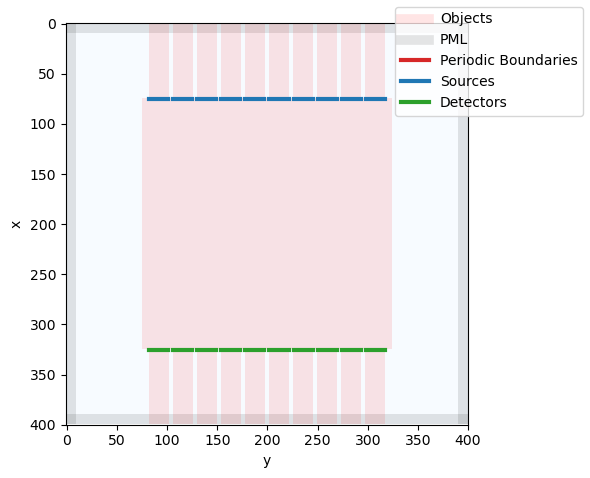

In [5]:
train_loader, test_loader = core_data_loader(batch_size=1)

radius_matrix = np.random.rand(10, 10)

it = 0
for data, labels in train_loader:
    silicon_plane = Init()
    silicon_plane = set_source(silicon_plane, data[0])
    silicon_plane = set_permittivity(silicon_plane, radius_matrix)
    # silicon_plane.run(cfg.time_step)
    silicon_plane.visualize(z=0)
    output = torch.tensor([], device=cfg.device)
    output2 = []
    for i in range(cfg.ports): # Ez的值作为输出，空间上取平均，时间上取和
        detector_values_E = torch.stack(silicon_plane.detectors[i].detector_values()["E"], dim=0)
        output = torch.cat([output, torch.mean(detector_values_E[:,:,-1]**2, dim=1).sum(dim=0).unsqueeze(-1)])
        output2.append(torch.mean(detector_values_E[:,:,-1]**2, dim=1).sum(dim=0))
    print(output)
    print(output2)
    break
